#SSD Object Detection Model To Detect Synthetic Fruits

##Import packages and mount google drive

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import os
import re

In [3]:
#mount the google drive to access the data 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Set the intial parameters for the object detection model and select which model will be used

In [4]:
# Set the parameters and what model will be used for the subsequent training and testing.
# Repository link to clone/use
repo_url = 'https://github.com/Tony607/object_detection_demo'

# Number of training steps.
num_steps = 25000  # 200000 Increase the steps as required.

# Number of evaluation steps.
num_eval_steps = 50

#Define the models to use (Already available in the object detection demo)
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colab's GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [5]:
%cd /content/gdrive/MyDrive/Fruit_with_more_epochs
!ls 

/content/gdrive/MyDrive/Fruit_with_more_epochs
'Copy of Faster_RCNN.ipynb'   RCNN_more_epoch_checkpoints   test_images
'Copy of SSD_Fruit.ipynb'     SSD_Fruit_Checkpoint
 Fruits_2		      SSD_more_epoch_checkpoints


##Download the required files and models for the object detection experiment

In [6]:
#clone the github and download the object detection models
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install lvis

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!pip install numpy==1.19.5
!pip uninstall -y pycocotools
!pip install pycocotools --no-binary pycocotools

!python object_detection/builders/model_builder_test.py

/content
     |████████████████████████████████| 352 kB 4.3 MB/s 
Selecting previously unselected package python-bs4.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to un

Found existing installation: pycocotools 2.0.4
Uninstalling pycocotools-2.0.4:
  Successfully uninstalled pycocotools-2.0.4
     |████████████████████████████████| 106 kB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=265199 sha256=98116b0c6c26519e8aad2bc10897d8b38df281c1c26f3274df69046f368dc902
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools
Using TensorFlow backend.


##Download the dataset Synthetic Fruits.

In [ ]:
#Download the tensorflow records into the desired directory
%cd /content/gdrive/MyDrive/Fruit_with_more_epochs/Fruits_2
!curl -L "https://public.roboflow.com/ds/CxFZTNurlF?key=0wCa7Ol6Uw" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content/gdrive/MyDrive/Fruit_with_more_epochs/Fruits_2
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   2189      0 --:--:-- --:--:-- --:--:--  2189
100  200M  100  200M    0     0  45.8M      0  0:00:04  0:00:04 --:--:-- 51.9M
Archive:  roboflow.zip
replace train/Fruits.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
#Set the training, testing and label map data
test_record_fname = '/content/gdrive/MyDrive/Fruit_with_more_epochs/Fruits_2/valid/Fruits.tfrecord' 
train_record_fname = '/content/gdrive/MyDrive/Fruit_with_more_epochs/Fruits_2/train/Fruits.tfrecord'
label_map_pbtxt_fname = '/content/gdrive/MyDrive/Fruit_with_more_epochs/Fruits_2/train/Fruits_label_map.pbtxt'

##Download the pretained model, extract the file and fine tune checkpoints

In [8]:
#Get the model file from the object detection folder from tensorflow.
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [9]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 23 root   root  4.0K May 12 00:54 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [10]:
#Fine tune checkpoint to enable retraining from a certain checkpoint
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

##Define the pipeline of the model and set up the training configurations

In [11]:
#Define the pipeline
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [12]:
#Function to get the number of classes from the label map stored above
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [13]:
#Configure the SSD model with the checkpoints, label maps and finally the training and validation inputs.
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [14]:
#Display the pipeline
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 63
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect

##Train the SSD Model

In [15]:
#Set where the checkpoints of the model will be saved
%cd /content/gdrive/MyDrive/Fruit_with_more_epochs/SSD_more_epoch_checkpoints
model_dir = '/content/gdrive/MyDrive/Fruit_with_more_epochs/SSD_Fruit_Checkpoint'

/content/gdrive/MyDrive/Fruit_with_more_epochs/SSD_more_epoch_checkpoints


In [ ]:
!pip install lvis
# Start training the model
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={20000} \
    --num_eval_steps={num_eval_steps}

Using TensorFlow backend.
W0510 06:23:26.073664 140575240836992 model_lib.py:839] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 20000
I0510 06:23:26.073906 140575240836992 config_util.py:552] Maybe overwriting train_steps: 20000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0510 06:23:26.074064 140575240836992 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0510 06:23:26.074237 140575240836992 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0510 06:23:26.074398 140575240836992 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0510 06:23:26.074572 140575240836992 model_lib.py:855] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs

In [16]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1652156547.4701f1f0c1ec
events.out.tfevents.1652159043.4701f1f0c1ec
events.out.tfevents.1652161408.4701f1f0c1ec
events.out.tfevents.1652163825.4701f1f0c1ec
export
graph.pbtxt
model.ckpt-15000.data-00000-of-00001
model.ckpt-15000.index
model.ckpt-15000.meta
model.ckpt-16486.data-00000-of-00001
model.ckpt-16486.index
model.ckpt-16486.meta
model.ckpt-17725.data-00000-of-00001
model.ckpt-17725.index
model.ckpt-17725.meta
model.ckpt-18964.data-00000-of-00001
model.ckpt-18964.index
model.ckpt-18964.meta
model.ckpt-20000.data-00000-of-00001
model.ckpt-20000.index
model.ckpt-20000.meta


##Evaluate the training with Tensorboard

In [17]:
%load_ext tensorboard

In [19]:
%tensorboard --logdir '/content/gdrive/MyDrive/Fruit_with_more_epochs/SSD_Fruit_Checkpoint'

Output hidden; open in https://colab.research.google.com to view.

##Evaluate SSD Model on subset of Test Images

###Create frozen inference of the SSD model for testing

In [20]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1652156547.4701f1f0c1ec
events.out.tfevents.1652159043.4701f1f0c1ec
events.out.tfevents.1652161408.4701f1f0c1ec
events.out.tfevents.1652163825.4701f1f0c1ec
export
graph.pbtxt
model.ckpt-15000.data-00000-of-00001
model.ckpt-15000.index
model.ckpt-15000.meta
model.ckpt-16486.data-00000-of-00001
model.ckpt-16486.index
model.ckpt-16486.meta
model.ckpt-17725.data-00000-of-00001
model.ckpt-17725.index
model.ckpt-17725.meta
model.ckpt-18964.data-00000-of-00001
model.ckpt-18964.index
model.ckpt-18964.meta
model.ckpt-20000.data-00000-of-00001
model.ckpt-20000.index
model.ckpt-20000.meta


In [21]:
#Convert the model checkpoints into a frozen inference graph
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

/content/gdrive/MyDrive/Fruit_with_more_epochs/SSD_Fruit_Checkpoint/model.ckpt-20000
Using TensorFlow backend.
Instructions for updating:
Please use `layer.__call__` method instead.
W0512 00:56:11.312059 140170591287168 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0512 00:56:13.880198 140170591287168 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0512 00:56:13.926491 140170591287168 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0512 00:56:13.970180 140170591287168 convolutional_box_p

In [22]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


In [23]:
import os
#save the frozen inference graph as the frame to use for testing
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [24]:
!ls -alh {pb_fname}

-rw------- 1 root root 24M May 12 00:56 /content/gdrive/MyDrive/Fruit_with_more_epochs/SSD_more_epoch_checkpoints/fine_tuned_model/frozen_inference_graph.pb


###Link the test folder and frozen inference model for testing 

In [25]:
dir_path = '/content/gdrive/MyDrive/Fruit_with_more_epochs'

In [26]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  '/content/gdrive/MyDrive/Fruit_with_more_epochs/test_images'

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/gdrive/MyDrive/Fruit_with_more_epochs/test_images/23_jpg.rf.d98d2b286b97389257412f819f29e374.jpg', '/content/gdrive/MyDrive/Fruit_with_more_epochs/test_images/41_jpg.rf.e6195546df062ee09197443780bc7672.jpg', '/content/gdrive/MyDrive/Fruit_with_more_epochs/test_images/14_jpg.rf.e9aa357dd44e790c3ad657d10a5511f3.jpg']


###Output of the SSD model on test images

/content/models/research/object_detection


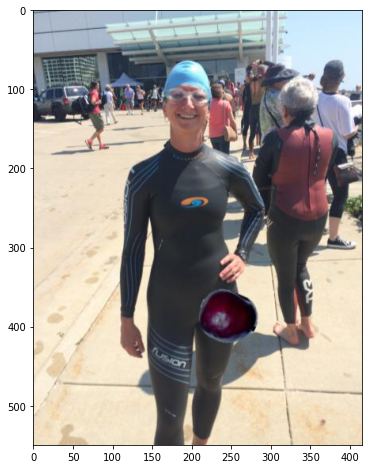

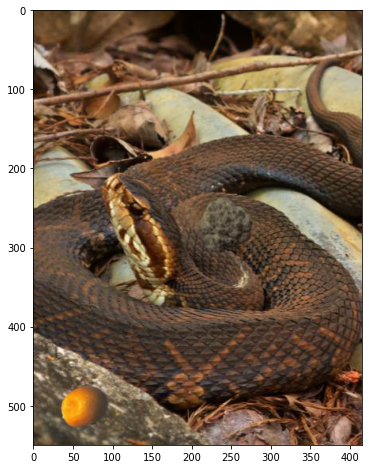

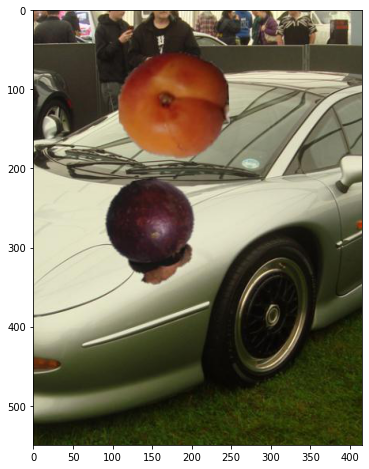

In [28]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)